In [ ]:
data_dir = r"./Plant Disease Data"


In [12]:

import math
import torch
from torch import nn


class NewGELUActivation(nn.Module):
    
    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a linear layer to project the query, key, and value
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Project the query, key, and value
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        # Resize the attention output
        # from (batch_size, num_attention_heads, sequence_length, attention_head_size)
        # To (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    """
    The transformer encoder modules
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
            # better to use
            # torch.nn.init.zeros_(module.bias)
            # torch.nn.init.ones_(module.weight)

        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset


class AugmentedDataset(Dataset):
    def __init__(self, dataset, num_augmentations):
        self.dataset = dataset
        self.num_augmentations = num_augmentations
        self.augmentations = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomGrayscale(p=0.2)
        ])

    def __len__(self):
        return len(self.dataset) * (self.num_augmentations + 1)

    def __getitem__(self, idx):
        original_idx = idx % len(self.dataset)
        img, label = self.dataset[original_idx]

        if idx >= len(self.dataset):  # Apply augmentation
            img = self.augmentations(img)

        return img, label

def prepare_data_plant(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None, num_augmentations=2):
  

    base_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load datasets
    trainset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=base_transform)
    testset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=base_transform)

    # Optionally limit dataset size
    if train_sample_size is not None and train_sample_size < len(trainset):
        trainset = Subset(trainset, range(train_sample_size))

    if test_sample_size is not None and test_sample_size < len(testset):
        testset = Subset(testset, range(test_sample_size))

    # Wrap trainset with augmentation
    trainset = AugmentedDataset(trainset, num_augmentations)

    return trainset, testset, trainset.dataset.classes


In [14]:
import re
from typing import Union, List, Tuple

def abbreviate_class(
    gt: Union[str, List[str]],
    pred: Union[str, List[str]],
    token_len: int = 2
) -> Tuple[Union[str, List[str]], Union[str, List[str]]]:
    """
    Abbreviate a single class-name or a list of them.
    Returns (gt_abbr, pred_abbr) in the same structure (str or List[str]).
    """
    def _abbr(name: str) -> str:
        # remove parentheses + contents
        no_paren = re.sub(r'\([^)]*\)', '', name)
        # split crop vs. disease on 3+ underscores
        parts = re.split(r'_{3,}', no_paren, maxsplit=1)
        crop = re.sub(r'[\s,]+', '_', parts[0].strip())
        disease = parts[1] if len(parts) > 1 else ''
        tokens = [t for t in re.split(r'[\s_]+', disease) if t]
        abbrevs = [t[:token_len].title() for t in tokens]
        return f"{crop}_{'.'.join(abbrevs)}" if abbrevs else crop

    def _process(x):
        if isinstance(x, list):
            return [_abbr(n) for n in x]
        else:
            return _abbr(x)

    return _process(gt), _process(pred)


In [ ]:
import json, os, math
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder



def save_experiment_plant(experiment_name, config, model,start_epoch, epochs, train_losses, test_losses, accuracies, mAPs,  base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    if os.path.exists(jsonfile):
        with open(jsonfile, 'r') as f:
            existing_data = json.load(f)
    else:
        existing_data = {
            'train_losses': [],
            'test_losses': [],
            'accuracies': [],
            'mAPs': [],
        }

    existing_data['train_losses'].extend(train_losses)
    existing_data['test_losses'].extend(test_losses)
    existing_data['accuracies'].extend(accuracies)
    existing_data['mAPs'].extend(mAPs)

    with open(jsonfile, 'w') as f:
        json.dump(existing_data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint_plant(experiment_name, model, start_epoch, epochs, base_dir=base_dir)


def save_checkpoint_plant(experiment_name, model,start_epoch, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save model state_dict and epoch
    checkpoint = {
        'epoch': start_epoch + epoch,
        'model_state_dict': model.state_dict()
    }
    cpfile = os.path.join(outdir, f'model_final.pt')
    torch.save(checkpoint, cpfile)
    print(f"Checkpoint saved at epoch {start_epoch + epoch}")


def load_experiment_plant(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    mAPs = data['mAPs']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    checkpoint = torch.load(cpfile)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    return config, model, train_losses, test_losses, accuracies, mAPs, epoch

def get_dataloader_plant(data_path, batch_size=32, shuffle=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)) # 32, 32
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = ImageFolder(root=data_path, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader, dataset.classes

def visualize_images_plant():
    train_loader, classes = get_dataloader_plant(os.path.join(data_dir, "train"), batch_size=30, shuffle=True)
    
    images, labels = next(iter(train_loader))
    images = images.permute(0, 2, 3, 1).numpy()
    # images = np.clip(images * 0.5 + 0.5, 0, 1)  # Unnormalize and clip values to [0,1]

    fig = plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow((images[i] * 0.5 + 0.5))  # Unnormalize the image
        ax.set_title(classes[labels[i]])
    saving_dir = '/home/siu855621720/Plant Disease Project/model images'
    plt.savefig(os.path.join(saving_dir, 'images.png'))
    plt.show()

@torch.no_grad()
def visualize_attention_plant(model, output=None, device="cuda"):
    model.eval()
    attention_folder = r'/home/siu855621720/Plant Disease Project/Plant Disease Data/test'
    test_loader, classes = get_dataloader_plant(
        os.path.join(attention_folder, ""), batch_size=10, shuffle=True
    )
    
    images, labels = next(iter(test_loader))
    raw_images = images.permute(0, 2, 3, 1).numpy()
    images = images.to(device)
    model = model.to(device)

    logits, attention_maps = model(images, output_attentions=True)
    predictions = torch.argmax(logits, dim=1)

    attention_maps = torch.cat(attention_maps, dim=1)
    attention_maps = attention_maps[:, :, 0, 1:].mean(dim=1)
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    attention_maps = F.interpolate(
        attention_maps.unsqueeze(1),
        size=(256, 256),
        mode='bilinear',
        align_corners=False
    ).squeeze(1)

    # ↑ changed here ↓
    fig = plt.figure(figsize=(12, 10))
    fig.subplots_adjust(wspace=0.2, hspace=0.4)

    mask = np.concatenate([np.ones((256, 256)), np.zeros((256, 256))], axis=1)

    for i in range(len(raw_images)):
        ax = fig.add_subplot(5, 2, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        img = np.clip(img, 0, 1)
        ax.imshow(img)

        extended_attention_map = np.concatenate(
            (np.zeros((256, 256)), attention_maps[i].cpu()),
            axis=1
        )
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')

        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        gt_abbr, pred_abbr = abbreviate_class(gt, pred)
        color = "green" if gt_abbr == pred_abbr else "red"
        ax.set_title(f"gt: {gt_abbr} / pred: {pred_abbr}", color=color)

    if output is not None:
        plt.savefig(output)
    plt.show()
    return raw_images, labels



In [ ]:
#@title Get Configuration
def get_config():

    patch_size = 16  #@param {type: "integer"}
    hidden_size = 768  #@param {type: "integer"}
    num_hidden_layers = 8  #@param {type: "integer"}
    num_attention_heads = 8  #@param {type: "integer"}
    intermediate_size = 3072  #@param {type: "integer"}  # 4 * hidden_size
    hidden_dropout_prob = 0.1  #@param {type: "number"}
    attention_probs_dropout_prob = 0.1  #@param {type: "number"}
    initializer_range = 0.02  #@param {type: "number"}
    image_size = 256  #@param {type: "integer"}
    num_classes = 38  #@param {type: "integer"}
    num_channels = 3  #@param {type: "integer"}
    qkv_bias = True  #@param {type: "boolean"}
    use_faster_attention = True  #@param {type: "boolean"}

    config = {
    "patch_size": patch_size,  # 256x256 -> 16x16 patches (each 16x16)
    "hidden_size": hidden_size,  # Increased to handle larger input size
    "num_hidden_layers": num_hidden_layers,  # More layers for deeper representation
    "num_attention_heads": num_attention_heads,  # More attention heads
    "intermediate_size": intermediate_size,  # 4 * hidden_size
    "hidden_dropout_prob": hidden_dropout_prob,  # Regularization
    "attention_probs_dropout_prob": attention_probs_dropout_prob,  # Regularization
    "initializer_range": initializer_range,
    "image_size": image_size,  # Updated to match your input size
    "num_classes": num_classes,  # Keeping the same number of classes
    "num_channels": num_channels,  # RGB images
    "qkv_bias": qkv_bias,
    "use_faster_attention": use_faster_attention
    }

    return config

In [17]:
vit_model = ViTForClassfication(get_config())
total_params = sum(p.numel() for p in vit_model.parameters() if p.requires_grad)
print(f"ViT trainable parameters: {total_params:,}")

ViT trainable parameters: 57,520,934


In [18]:
#@title Train ViT

import torch
from torch import nn, optim
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

exp_name = 'vit-plant(2nd exp)' #@param {type:"string"}
batch_size = 32 #@param {type: "integer"}
epochs = 1 #@param {type: "integer"}
lr = 1e-4  #@param {type: "number"}
save_model_every = 10 #@param {type: "integer"}

config = get_config()
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, start_epoch, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies, mAPs = [], [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss, mAP = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            mAPs.append(mAP)
            print(f"Epoch: {start_epoch+i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', start_epoch+i+1)
                save_checkpoint_plant(self.exp_name, self.model, start_epoch, i+1)
        # Save the experiment
        
        saving_dir = os.path.join(data_dir, 'experiments')
        save_experiment_plant(self.exp_name, config, self.model,start_epoch, epochs,
                                 train_losses, test_losses, accuracies,mAPs,
                                 saving_dir)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        all_labels = []
        all_scores = []
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()

               # Store labels and softmax scores
                all_labels.append(labels.cpu().numpy())
                all_scores.append(torch.softmax(logits, dim=1).cpu().numpy())

                # # Store labels and scores for mAP calculation
                # all_labels.append(labels.cpu().numpy())
                # # scores = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
                # scores = torch.softmax(logits, dim=1).cpu().numpy()
                # # all_scores.append(scores)
                # # scores = torch.softmax(logits, dim=1)  # Get probabilities for all classes
                # all_scores.append(scores[np.arange(len(labels)), labels.cpu().numpy()])
                # # all_scores.append(scores.cpu().numpy())
        all_labels = np.concatenate(all_labels, axis=0)
        all_scores = np.concatenate(all_scores, axis=0)

        num_classes = all_scores.shape[1]  # Number of classes from softmax output


        if num_classes > 2:
            # Multi-class: Convert labels to one-hot encoding
            all_labels = label_binarize(all_labels, classes=np.arange(num_classes))
            mAP = average_precision_score(all_labels, all_scores, average='macro')
        else:
            # Binary case: `all_labels` should be 1D
            mAP = average_precision_score(all_labels, all_scores[:, 1])  # Use scores of positive class


        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        # Compute mean Average Precision (mAP)
        # all_labels = np.concatenate(all_labels, axis=0)
        # all_scores = np.concatenate(all_scores, axis=0)
        # mAP = average_precision_score(all_labels, all_scores, average='macro')
        return accuracy, avg_loss, mAP

def main():
    # Load config and model
    config = get_config()
    model = ViTForClassfication(config)  
    base_dir = data_dir
    # Load existing checkpoint if available
    experiment_name = 'vit-plant(2nd exp)'
    base_dir = os.path.join(base_dir, 'experiments')
    checkpoint_name = "model_final.pt"

    try:
        config, model, train_losses, test_losses, \
        accuracies, mAPs, start_epoch = load_experiment_plant(experiment_name,
                                                                 checkpoint_name,
                                                                 base_dir)
        print(f"Resuming training from epoch {start_epoch}")
    except FileNotFoundError:
        config = get_config()
        model = ViTForClassfication(config)
        start_epoch = 0

    # Get datasets and create DataLoaders
    trainset, testset, _ = prepare_data_plant(batch_size=batch_size, num_augmentations=0)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()

    # Initialize trainer and train model
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, start_epoch, epochs, save_model_every_n_epochs=save_model_every)

if __name__ == '__main__':
    main()


Resuming training from epoch 21
Epoch: 22, Train loss: 0.0535, Test loss: 0.1005, Accuracy: 0.9739
Checkpoint saved at epoch 22


In [19]:
from sklearn.metrics import accuracy_score

# Load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_path = os.path.join(data_dir, 'experiments/vit-plant(2nd exp)/model_final.pt')

checkpoint = torch.load(model_path, map_location=device)
model = ViTForClassfication(get_config())
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_dir = os.path.join(data_dir, 'test')

val_dataset = ImageFolder(val_dir, transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# predictions and calculate accuracy
all_preds_val = []
all_labels_val = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs[0], 1)
        print(predicted)
        all_preds_val.extend(predicted.cpu().numpy())
        all_labels_val.extend(labels.cpu().numpy())

accuracy_val = accuracy_score(all_labels_val, all_preds_val)
print(f"Validation Accuracy: {accuracy_val}")

tensor([ 0,  0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([ 0,  0,  0,  0,  0,  0,  0, 25,  0,  0,  0,  0,  0,  0,  0,  0,  5,  5,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0')
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0

In [10]:
from sklearn.metrics import classification_report, accuracy_score

# get the full report as a dict
report = classification_report(
    all_labels_val,
    all_preds_val,
    target_names=val_dataset.classes,
    output_dict=True
)

# overall accuracy
accuracy = accuracy_score(all_labels_val, all_preds_val)

# pick out the macro‐ and weighted‐ averages
macro = report["macro avg"]
weighted = report["weighted avg"]

print(f"Accuracy (overall) : {accuracy:.3f}")
print(f"Macro Avg Precision : {macro['precision']:.3f}")
print(f"Macro Avg Recall    : {macro['recall']:.3f}")
print(f"Macro Avg F1-Score  : {macro['f1-score']:.3f}")
print()
print(f"Weighted Avg Precision : {weighted['precision']:.3f}")
print(f"Weighted Avg Recall    : {weighted['recall']:.3f}")
print(f"Weighted Avg F1-Score  : {weighted['f1-score']:.3f}")


Accuracy (overall) : 0.979
Macro Avg Precision : 0.979
Macro Avg Recall    : 0.979
Macro Avg F1-Score  : 0.979

Weighted Avg Precision : 0.980
Weighted Avg Recall    : 0.979
Weighted Avg F1-Score  : 0.979


In [ ]:

print(classification_report(all_labels_val, all_preds_val, target_names=val_dataset.classes))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.99      0.99       504
                                 Apple___Black_rot       1.00      0.96      0.98       497
                          Apple___Cedar_apple_rust       0.98      0.97      0.97       440
                                   Apple___healthy       0.99      0.99      0.99       502
                               Blueberry___healthy       0.99      0.98      0.98       454
          Cherry_(including_sour)___Powdery_mildew       0.99      1.00      0.99       421
                 Cherry_(including_sour)___healthy       0.98      1.00      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.94      0.95       312
                       Corn_(maize)___Common_rust_       1.00      0.97      0.98       477
               Corn_(maize)___Northern_Leaf_Blight       0.96      0.97      0.

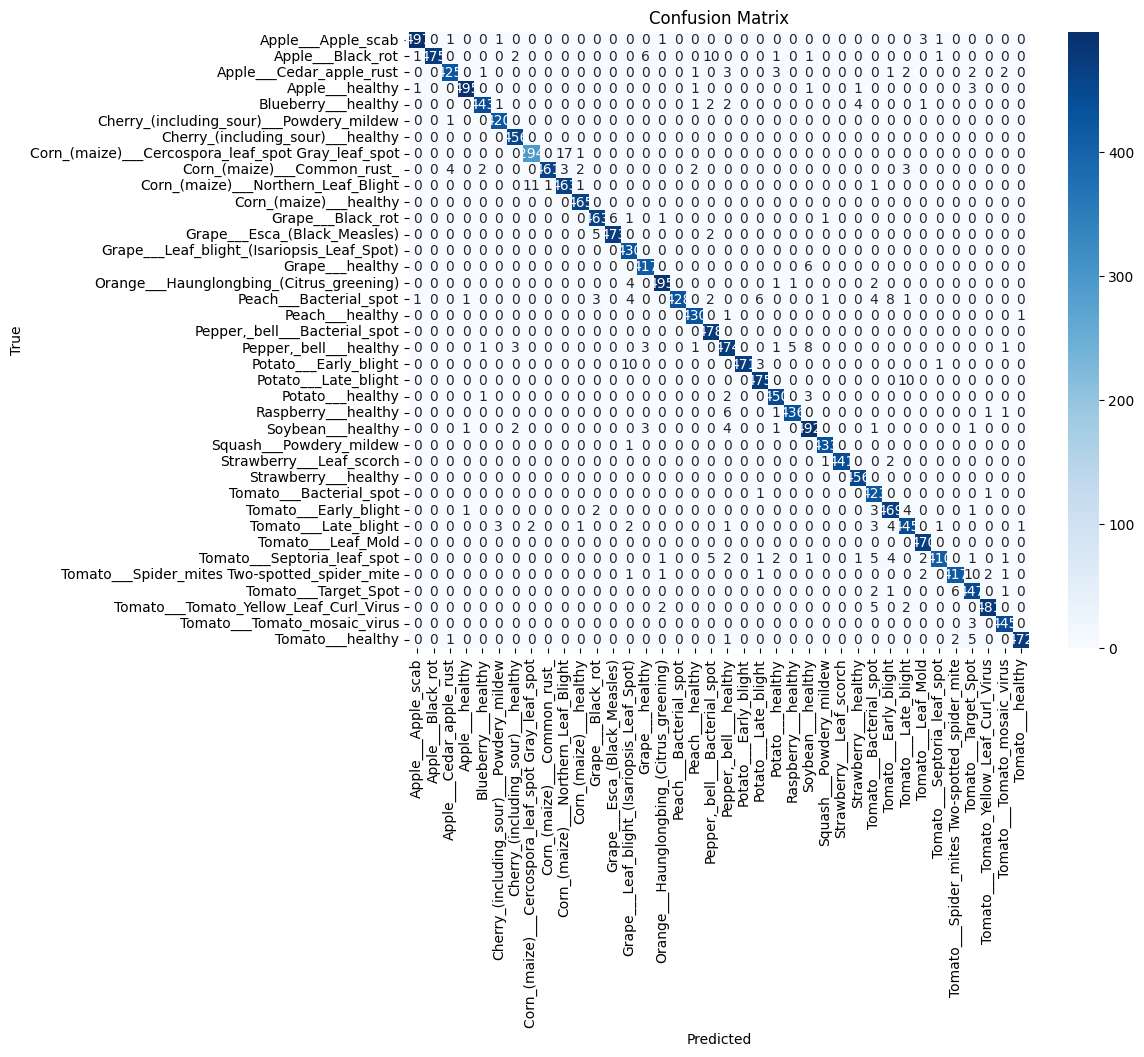

In [13]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(all_labels_val, all_preds_val)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


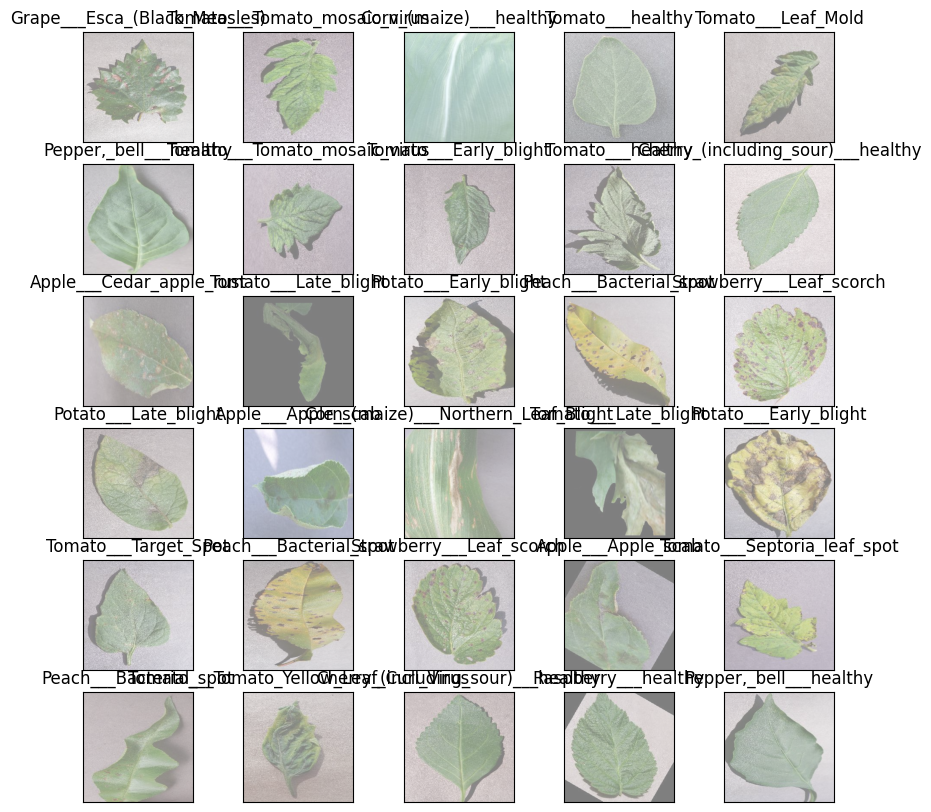

In [14]:
visualize_images_plant()

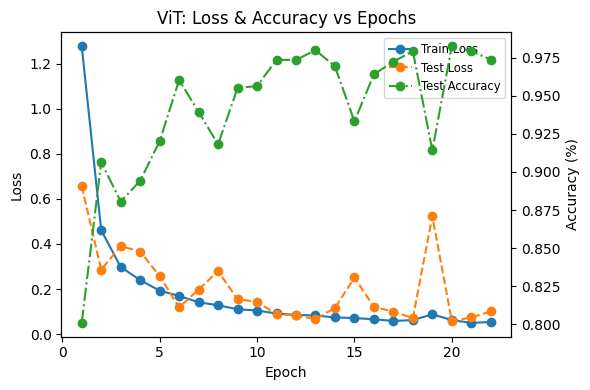

In [21]:
exp_name = 'vit-plant(2nd exp)'
base_dir = '/home/siu855621720/Plant Disease Project/Plant Disease Data/experiments'
checkpoint_name = 'model_final.pt'
config, model, train_losses, test_losses, accuracies, mAPs, epoch = load_experiment_plant(exp_name, checkpoint_name, base_dir)

epochs = list(range(1, len(train_losses)+1))

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot train & test loss on left y-axis
ax1.plot(epochs, train_losses, label="Train Loss", linestyle='-', marker='o')
ax1.plot(epochs, test_losses,  label="Test Loss", linestyle='--', marker='o')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.tick_params(axis='y')

# Plot accuracy on right y-axis
ax2 = ax1.twinx()
ax2.plot(epochs, accuracies, label="Test Accuracy", color='tab:green', linestyle='-.', marker='o')
ax2.set_ylabel("Accuracy (%)")
ax2.tick_params(axis='y')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize='small')

plt.title(f"ViT: Loss & Accuracy vs Epochs")
plt.tight_layout()
plt.savefig("Evaluation.png")
plt.show()


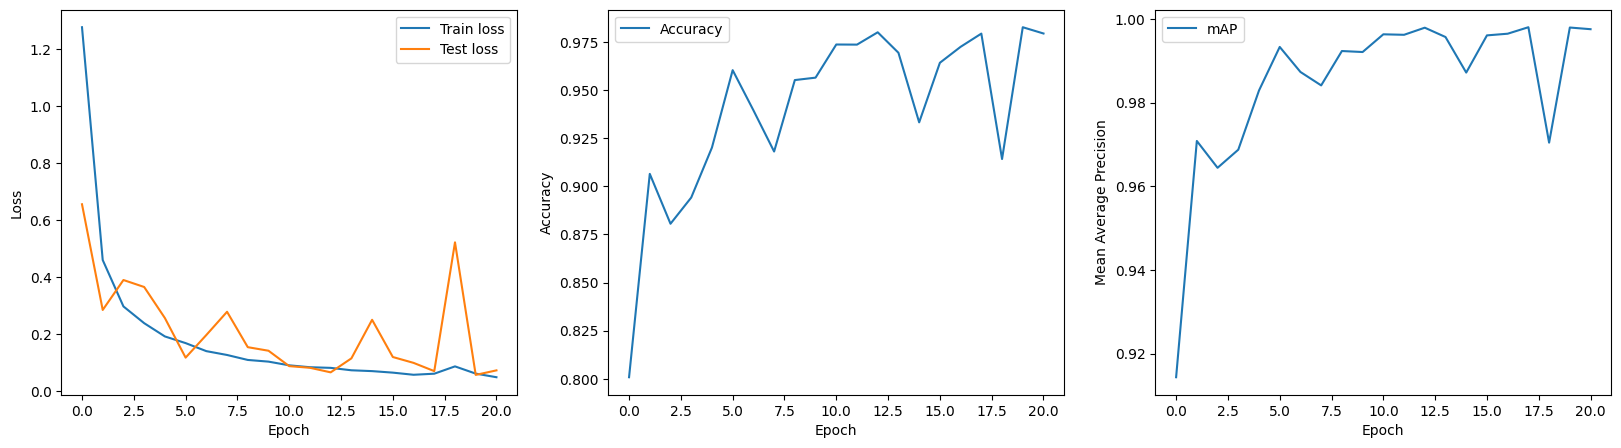

In [17]:
#@title Plot training Results
exp_name = 'vit-plant(2nd exp)'
base_dir = '/home/siu855621720/Plant Disease Project/Plant Disease Data/experiments'
checkpoint_name = 'model_final.pt'
config, model, train_losses, test_losses, accuracies, mAPs, epoch = load_experiment_plant(exp_name, checkpoint_name, base_dir)

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies, label="Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax3.plot(mAPs, label="mAP")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Mean Average Precision")
ax3.legend()
plt.savefig("/home/siu855621720/Plant Disease Project/model images/sample_images.png")
plt.show()

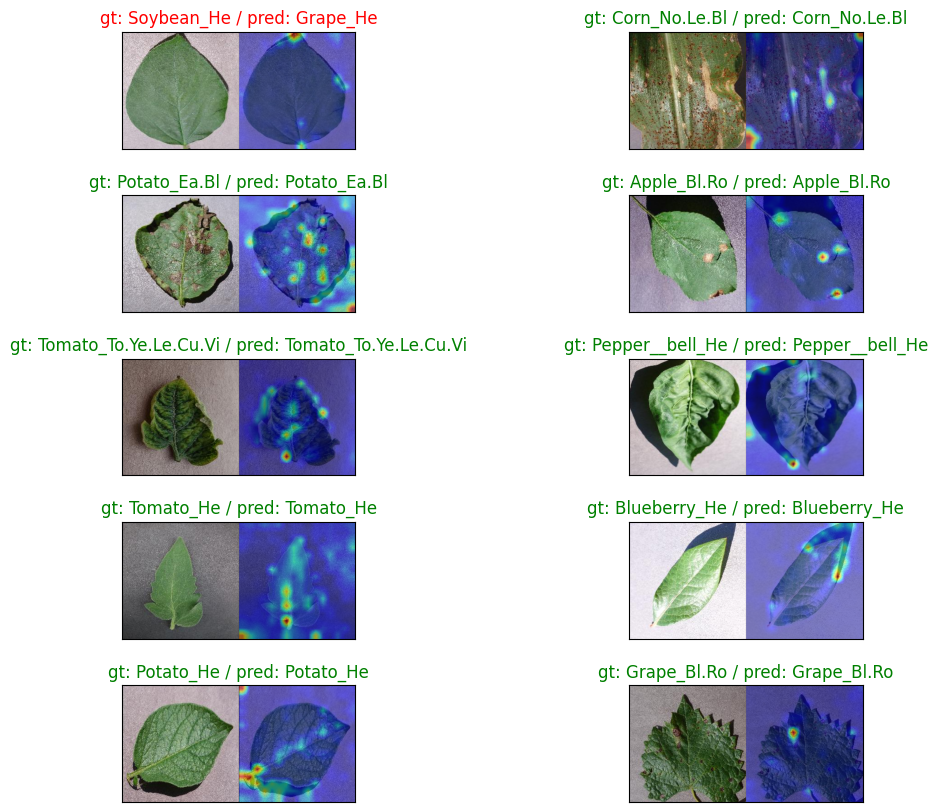

In [23]:
#@title Visualize Attetion
raw_images, labels= visualize_attention_plant(model, "attention.png")

# **Vision Transformer Credit**

https://github.com/tintn/vision-transformer-from-scratch/blob/main/vision_transformers.ipynb